# Group Surveys Feature Determination

## Preparation

### Import

In [ ]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy import interp
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

## Function Definition

### Inlcude Marks Classification

In [ ]:
def include_mark_classification(df):

    df = df[df['theory'] >= 0.5]
    limit1=0.65
    limit2= 0.8

    # Define the conditions and corresponding values
    conditions = [
        (df['theory'] >= 0.5) & (df['theory'] < limit1),
        (df['theory'] >= limit1) & (df['theory'] < limit2),
        (df['theory'] >= limit2) & (df['theory'] <= 1)
    ]
    values = [1,2,3]

    # Create the 'mark' column using np.select()
    df['mark'] = np.select(conditions, values, default='np.NaN')

    df = df.dropna(how='any')

    return df

### Inlcude Groupflow Classification

In [ ]:
import pandas as pd

def assign_groupflow(df):
    # Create a new column 'groupflow' with default value as None
    df['groupflow'] = None

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Get the values of the three columns for the current row
        beeflow = row['Groupflow_Beeflow']
        leechflow = row['Groupflow_Leechflow']
        antflow = row['Groupflow_Antflow']

        # Compare the values and assign the corresponding category to 'groupflow'
        if beeflow >= leechflow and beeflow >= antflow:
            df.at[index, 'groupflow'] = 'bee'
        elif leechflow >= beeflow and leechflow >= antflow:
            df.at[index, 'groupflow'] = 'leech'
        else:
            df.at[index, 'groupflow'] = 'ant'

    # Return the modified DataFrame
    return df


### Select Columns by Index

In [ ]:
def select_columns_by_index(df, column_indexes):

    cols= column_indexes
    cols.append(len(df.columns)-1)
    selected_columns = df.iloc[:, cols].copy()
    selected_column_names = df.columns[column_indexes].tolist()

    return selected_columns, selected_column_names

### Prepare DataFrame for Modeling

In [ ]:
def prepare_df_for_modeling(df):

  # Strip off leading and trailing whitespace from non-numeric columns
  df = df.select_dtypes(include=['int', 'float'])
  df = df[df['theory'] >= 0.5]
  df.reset_index(drop=True, inplace=True)

  return df

### Return Dataframe by Columns

In [ ]:
def return_df_by_columns(df,column_names):

  new_df = df[column_names].copy()
  data = pd.concat([new_df, df['theory']], axis=1)

  return data

### Get Indexes by Column names

In [ ]:
def get_column_indexes(df, columns):
    # Get the indexes of the specified columns
    indexes = [df.columns.get_loc(col) for col in columns]
    return indexes

## Use of Function

### Import

In [ ]:
in_file= r'/content/drive/MyDrive/Projects/tps/finals/data/3_individual_features.xlsx'

# Read the Excel file into a DataFrame, using 'Id' column as the index
df= pd.read_excel(in_file, index_col='Id')

### Cleaning

In [ ]:
# Drop unnecesary columns
not_used_columns=['avg_time_without_speaking_ratio', 'max_time_without_speaking_ratio', 'avg_turns_without_speaking_ratio', 'max_turns_without_speaking_ratio', 'avg_words_turn_ratio', 'max_words_turn', 'max_words_turn_ratio', 'messages_total', 'alter_art', 'alter_nudges', 'complexity_avg', 'dummy_question1', 'dummy_question2', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'conservation', 'transcendence', 'coeval', 'project']
df.drop(columns=not_used_columns, inplace=True)

# Transform marks into 0-1
df['theory'] = df['theory'] / 6

In [ ]:
df.head()

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,sentiment_avg,emotionality_avg,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory,mark,groupflow
0,526,0.148336,7.850746,0.126865,56.210746,451.54,67,0.331683,1.985075,7,978,0.170800,14.597015,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,34,-0.64,0.303561,0.215562,1,0.487649,0.472084,0.083889,0.089140,0.354886,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.716667,0.600000,0.633333,0.583333,27,23,19,18,20,0.573333,1,bee
1,2648,0.746757,33.948718,0.548598,21.791169,109.24,78,0.386139,1.589744,9,3816,0.666434,48.923077,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,75,-0.34,0.250396,0.236507,2,0.398994,0.438515,0.040232,0.107725,0.413528,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.666667,0.700000,0.616667,0.633333,22,28,11,7,11,0.606667,1,ant
2,105,0.029611,8.076923,0.130520,57.649231,141.72,13,0.064356,6.461538,15,267,0.046629,20.538462,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,38,-0.60,0.381860,0.254014,2,0.501416,0.157377,0.028980,0.053947,0.759697,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.683333,0.716667,0.533333,0.716667,23,28,9,6,7,0.663333,2,ant
3,162,0.045685,6.480000,0.104714,159.421600,836.46,25,0.123762,6.600000,29,394,0.068809,15.760000,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,27,-0.70,0.250852,0.259828,2,0.493443,0.258578,0.073231,0.112001,0.556190,0.319698,0.322770,0.225624,0.131909,0.256794,0.232465,0.510740,2.166667,1.500000,1.000000,4.166667,4.833333,2.733333,5.833333,6.000000,6.333333,5.000000,4.166667,5,0.566667,0.783333,0.733333,0.733333,0.633333,17,24,17,13,8,0.703333,2,ant
4,105,0.029611,5.526316,0.089303,43.632632,169.20,19,0.094059,4.526316,17,271,0.047328,14.263158,0.746439,0.193365,0.054215,0.005981,0.303593,0.235377,0.233832,0.227198,22,-0.75,0.305600,0.244289,1,0.555323,0.362543,0.000314,0.136496,0.500648,0.157227,0.472688,0.321906,0.048179,0.342162,0.120088,0.537751,3.166667,2.666667,3.500000,5.166667,3.666667,3.633333,3.666667,5.833333,3.666667,3.000000,3.666667,4,0.600000,0.666667,0.483333,0.583333,0.433333,12,15,11,19,4,0.623333,1,ant


In [ ]:
df.head(70)

,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,sentiment_avg,emotionality_avg,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory,mark,groupflow
0,526,0.148336,7.850746,0.126865,56.210746,451.54,67,0.331683,1.985075,7,978,0.170800,14.597015,0.832695,0.137502,0.026347,0.003456,0.298809,0.236814,0.232361,0.232015,34,-0.64,0.303561,0.215562,1,0.487649,4.720845e-01,8.388939e-02,0.089140,3.548859e-01,0.236101,0.407447,0.251288,0.105165,0.497477,0.156358,0.346165,4.500000,3.500000,4.166667,3.166667,3.500000,3.766667,4.833333,5.666667,5.666667,5.833333,4.833333,5,0.600000,0.716667,0.600000,0.633333,0.583333,27,23,19,18,20,0.573333,1,bee
1,2648,0.746757,33.948718,0.548598,21.791169,109.24,78,0.386139,1.589744,9,3816,0.666434,48.923077,0.795958,0.155654,0.045315,0.003074,0.292950,0.239695,0.227768,0.239587,75,-0.34,0.250396,0.236507,2,0.398994,4.385152e-01,4.023221e-02,0.107725,4.135278e-01,0.215535,0.417419,0.208064,0.158982,0.300955,0.220056,0.478989,2.000000,1.500000,1.000000,5.166667,5.500000,3.033333,4.000000,6.666667,6.500000,5.500000,3.000000,5,0.533333,0.666667,0.700000,0.616667,0.633333,22,28,11,7,11,0.606667,1,ant
2,105,0.029611,8.076923,0.130520,57.649231,141.72,13,0.064356,6.461538,15,267,0.046629,20.538462,0.789103,0.161515,0.037497,0.011885,0.297727,0.238513,0.230916,0.232844,38,-0.60,0.381860,0.254014,2,0.501416,1.573771e-01,2.897965e-02,0.053947,7.596967e-01,0.245048,0.410218,0.190879,0.153855,0.226931,0.238211,0.534858,4.500000,3.500000,2.666667,6.000000,6.000000,4.533333,5.000000,5.500000,5.500000,4.333333,2.833333,5,0.566667,0.683333,0.716667,0.533333,0.716667,23,28,9,6,7,0.663333,2,ant
3,162,0.045685,6.480000,0.104714,159.421600,836.46,25,0.123762,6.600000,29,394,0.068809,15.760000,0.712697,0.196289,0.077861,0.013153,0.300100,0.235307,0.232877,0.231716,27,-0.70,0.250852,0.259828,2,0.493443,2.585777e-01,7.323091e-02,0.112001,5.561903e-01,0.319698,0.322770,0.225624,0.131909,0.256794,0.232465,0.510740,2.166667,1.500000,1.000000,4.166667,4.833333,2.733333,5.833333,6.000000,6.333333,5.000000,4.166667,5,0.566667,0.783333,0.733333,0.733333,0.633333,17,24,17,13,8,0.703333,2,ant
4,105,0.029611,5.526316,0.089303,43.632632,169.20,19,0.094059,4.526316,17,271,0.047328,14.263158,0.746439,0.193365,0.054215,0.005981,0.303593,0.235377,0.233832,0.227198,22,-0.75,0.305600,0.244289,1,0.555323,3.625429e-01,3.140000e-04,0.136496,5.006478e-01,0.157227,0.472688,0.321906,0.048179,0.342162,0.120088,0.537751,3.166667,2.666667,3.500000,5.166667,3.666667,3.633333,3.666667,5.833333,3.666667,3.000000,3.666667,4,0.600000,0.666667,0.483333,0.583333,0.433333,12,15,11,19,4,0.623333,1,ant
5,1346,0.337682,8.518987,0.185779,19.887848,169.82,158,0.364055,1.740506,9,4025,0.329109,25.474684,0.768060,0.181860,0.043375,0.006704,0.297780,0.237582,0.227811,0.236827,22,-0.36,0.404612,0.268756,4,0.520000,3.625971e-01,1.342965e-01,0.001890,5.012164e-01,0.152454,0.624326,0.145505,0.077715,0.332323,0.221886,0.445791,1.833333,3.833333,3.666667,6.166667,5.500000,4.200000,3.500000,4.000000,6.333333,4.333333,2.833333,4,0.683333,0.733333,0.883333,

In [ ]:
df = assign_groupflow(df)


### Preparation

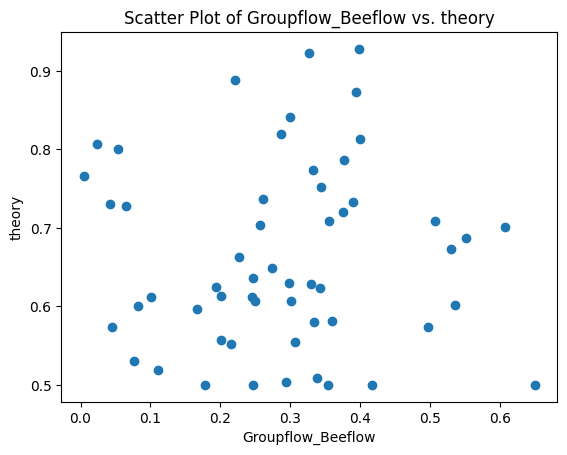

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Select the columns 'Groupflow_Beeflow' and 'theory'
selected_columns = df[['Groupflow_Beeflow', 'theory']]

# Plot a scatter plot
plt.scatter(selected_columns['Groupflow_Beeflow'], selected_columns['theory'])
plt.xlabel('Groupflow_Beeflow')
plt.ylabel('theory')
plt.title('Scatter Plot of Groupflow_Beeflow vs. theory')

# Display the plot
plt.show()


In [ ]:
# Make sure every column is composed by numbers
df= prepare_df_for_modeling(df)

# Include the classification (new column: 'mark')
df= include_mark_classification(df)

In [ ]:

# Group the DataFrame by 'mark' and calculate the average of other columns
grouped_df = df.groupby('mark').mean()

grouped_df.head()


,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,sentiment_avg,emotionality_avg,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory
mark,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,633.133333,0.211852,11.638873,0.213002,72.145966,627.696667,49.433333,0.200377,4.664250,31.566667,1329.000000,0.210984,25.064528,0.792493,0.178984,0.025318,0.003206,0.293840,0.237682,0.234083,0.234395,31.900000,-0.639000,0.381294,0.272791,2.866667,0.481637,0.268946,0.080709,0.156330,0.494014,0.205704,0.468833,0.196784,0.128678,0.273088,0.181244,0.545668,3.061111,3.666667,3.594444,5.233333,5.166667,4.144444,4.588889,5.227778,5.083333,4.238889,3.483333,4.433333,0.621111,0.675000,0.658889,0.604444,0.548333,20.233333,21.766667,16.566667,14.566667,12.833333,0.572389
2,4098.411765,0.212928,12.863763,0.212254,96.742884,3406.538824,161.352941,0.202204,5.362742,29.058824,4139.470588,0.203808,24.541950,0.786723,0.175513,0.031701,0.006062,0.288810,0.240940,0.236963,0.233287,19.411765,-0.578824,0.360572,0.228439,2.176471,0.480445,0.334654,0.054918,0.075818,0.534609,0.195958,0.474192,0.208322,0.121528,0.310736,0.187877,0.501387,2.313725,2.470588,2.460784,4.392157,5.058824,3.339216,4.745098,5.617647,5.647059,4.558824,3.196078,4.705882,0.610784,0.710784,0.678431,0.622549,0.556863,22.352941,23.411765,14.176471,13.882353,12.764706,0.727745
3,920.625000,0.137845,8.237331,0.152557,152.777560,9855.180000,132.750000,0.172704,7.351467,94.875000,2173.750000,0.152714,20.273865,0.804051,0.164769,0.027591,0.003590,0.286585,0.240915,0.240299,0.232201,20.250000,-0.575000,0.371942,0.227397,3.125000,0.490459,0.260956,0.043870,0.142861,0.552312,0.218862,0.456523,0.187953,0.136662,0.294069,0.215151,0.490780,2.250000,2.354167,2.145833,3.979167,4.958333,3.137500,5.104167,5.520833,5.854167,5.020833,4.083333,5.000000,0.593750,0.691667,0.604167,0.622917,0.550000,22.000000,24.000000,16.125000,16.875000,14.750000,0.861875


In [ ]:
# Group the DataFrame by 'mark' and calculate the average of other columns
grouped_df = df.groupby('groupflow').mean()

grouped_df.head()

<ipython-input-22-751306c03663>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby('groupflow').mean()


,indiv_spoken_time,indiv_spoken_time_ratio,average_turn_duration,average_turn_duration_ratio,avg_time_without_speaking,max_time_without_speaking,num_turns,num_turns_ratio,avg_turns_without_speaking,max_turns_without_speaking,num_words,num_words_ratio,avg_words_turn,speech_neu,speech_ang,speech_hap,speech_sad,text_joy,text_anger,text_fear,text_sadness,messages_sent,contribution_index,sentiment_avg,emotionality_avg,contribution_index_oscillation,activity_entanglement,ALTERNATIVE_REALITIES_Treehugger,ALTERNATIVE_REALITIES_Fatherlander,ALTERNATIVE_REALITIES_Spiritualism,ALTERNATIVE_REALITIES_Nerd,EMOTIONS_Fear,EMOTIONS_Happy,EMOTIONS_Sad,EMOTIONS_Anger,Groupflow_Beeflow,Groupflow_Leechflow,Groupflow_Antflow,ethical_likelihood,financial_likelihood,health_likelihood,recreational_likelihood,social_likelihood,total_likelihood,ethical_perceived,financial_perceived,health_perceived,recreational_perceived,social_perceived,total_perceived,O,C,E,A,N,harm_care_score,fairness_reciprocity_score,in_group_loyality_score,authority_respect_score,purity_sanctity_score,theory
groupflow,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ant,1964.150000,0.214219,10.785191,0.207717,81.561421,1751.176500,88.100000,0.201226,4.979334,28.625000,2315.900000,0.208128,23.334506,0.786891,0.180288,0.028625,0.004196,0.292954,0.239750,0.233128,0.234169,23.425000,-0.607500,0.363341,0.256860,2.600000,0.484810,0.298458,0.051611,0.143831,0.506100,0.198721,0.463484,0.208388,0.129407,0.224293,0.177810,0.597898,2.766667,3.095833,3.045833,4.654167,5.120833,3.736667,4.683333,5.395833,5.300000,4.495833,3.533333,4.575000,0.618750,0.687500,0.661250,0.616667,0.549583,20.75,22.925000,15.750000,13.825000,12.400000,0.666500
bee,1205.642857,0.170833,13.947778,0.197803,121.740108,6059.735714,120.071429,0.188670,6.048879,71.428571,2391.285714,0.183338,27.120184,0.800345,0.169487,0.026000,0.004168,0.287020,0.238163,0.242082,0.232735,34.928571,-0.602143,0.402274,0.243703,2.785714,0.473491,0.279049,0.092469,0.088395,0.540087,0.216887,0.492100,0.173703,0.117310,0.468755,0.198635,0.332610,2.535714,3.119048,2.976190,5.071429,5.059524,3.752381,4.869048,5.380952,5.654762,4.476190,3.428571,4.714286,0.598810,0.694048,0.644048,0.605952,0.560714,23.00,21.785714,16.071429,17.214286,15.642857,0.662500
leech,587.000000,0.117682,7.072289,0.140902,64.410120,700.140000,83.000000,0.139966,6.048193,55.000000,1517.000000,0.124100,18.277108,0.901034,0.087045,0.010155,0.001766,0.281229,0.229487,0.258993,0.230291,23.000000,-0.880000,0.378586,0.200108,5.000000,0.519054,0.000180,0.346846,0.130924,0.522050,0.268045,0.349683,0.181261,0.201011,0.293414,0.459167,0.247419,3.000000,3.333333,3.333333,6.333333,5.000000,4.200000,3.666667,5.333333,4.166667,2.333333,2.166667,4.000000,0.633333,0.650000,0.666667,0.550000,0.483333,11.00,21.000000,12.000000,14.000000,5.000000,0.503333


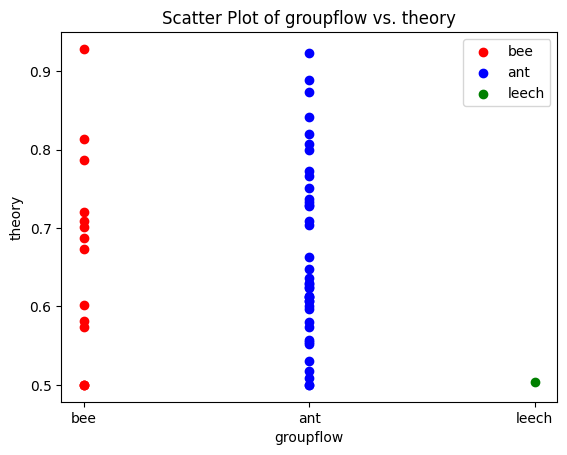

In [ ]:
modified_df = df

# Assuming your modified DataFrame is named 'modified_df'

# Get unique categories in 'groupflow' column
categories = modified_df['groupflow'].unique()

# Define colors for each category
colors = ['red', 'blue', 'green']  # Add more colors if needed

# Plot the data for each category
for i, category in enumerate(categories):
    # Filter the DataFrame for the current category
    category_df = modified_df[modified_df['groupflow'] == category]

    # Plot a scatter plot for the current category
    plt.scatter(category_df['groupflow'], category_df['theory'], color=colors[i], label=category)

# Set labels and title
plt.xlabel('groupflow')
plt.ylabel('theory')
plt.title('Scatter Plot of groupflow vs. theory')

# Add legend
plt.legend()

# Display the plot
plt.show()


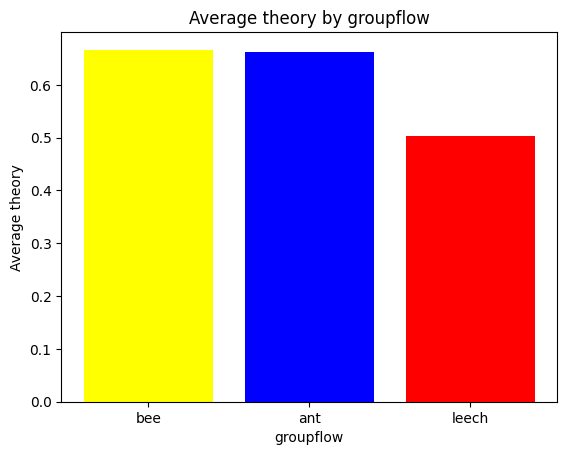

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your modified DataFrame is named 'modified_df'

# Calculate the average value of 'theory' for each category
avg_theory = modified_df.groupby('groupflow')['theory'].mean()

# Get unique categories in 'groupflow' column
categories = modified_df['groupflow'].unique()

# Define colors for each category
colors = ['yellow', 'blue', 'red']  # Add more colors if needed

# Plot the average value for each category as a histogram
plt.bar(categories, avg_theory, color=colors)

# Set labels and title
plt.xlabel('groupflow')
plt.ylabel('Average theory')
plt.title('Average theory by groupflow')

# Display the plot
plt.show()


In [ ]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:


# Ssaling informative variables
df= min_max_scaling_df(df,df.columns.to_list()[:-2])

# Drop the mark itself
df.drop(columns=['theory'], inplace=True)

In [ ]:
df.head()

### Feature Selection

In [ ]:
# Select the features
features_names= ['speech_hap', 'emotionality_avg', 'health_likelihood', 'E', 'indiv_spoken_time_ratio', 'contribution_index']

# Get Features Indexes
features_indexes= get_column_indexes(df, features_names)

# Get the DataFrame with the features selected
df,columns = select_columns_by_index(df, features_indexes)

In [ ]:
df.head(50)

In [ ]:
df.shape